# Theory validation experiment: Expressive power of the variational linear quantum photonic circuit (dependent of photon number)

The goal here will be to fit a degree 3 Fourier series g(x) with a Variational Quantum Circuit (VQC) using MerLin for the optimization. Since this is a fitting task, we won't use a validation or test dataset because our goal is to overfit on the data to assess the expressivity of a VQC.

As we will see, the expressivity of a VQC depends on the number of photons sent through the quantum circuit.

This notebook presents an experiment from the paper: [Fock State-enhanced Expressivity of Quantum Machine Learning Models](https://arxiv.org/abs/2107.05224).

## 0. Imports and prep

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from merlin import ComputationSpace, MeasurementStrategy, QuantumLayer

## 1. Define input domain, x, and target function g(x)

In [2]:
x = np.arange(-3 * np.pi, 3 * np.pi + 0.01, 0.05)

# Fourier coefficents
c_0 = 0.2
c_1 = 0.69 + 0.52j
c_2 = 0.81 + 0.41j
c_3 = 0.68 + 0.82j
# We want real valued g(x) so we have c_{-n} = conjugate( c_{n})
coefs = np.array([np.conj(c_3), np.conj(c_2), np.conj(c_1), c_0, c_1, c_2, c_3])
n = np.arange(-3, 4, 1)

# Compute the Fourier series sum
g = np.zeros_like(x, dtype=complex)
for k, c in zip(n, coefs, strict=False):
    g += c * np.exp(1j * k * x)

# g should be real valued
assert np.allclose(g, g.real), "g != g.real"
g = g.real

 Let's visualize g(x)

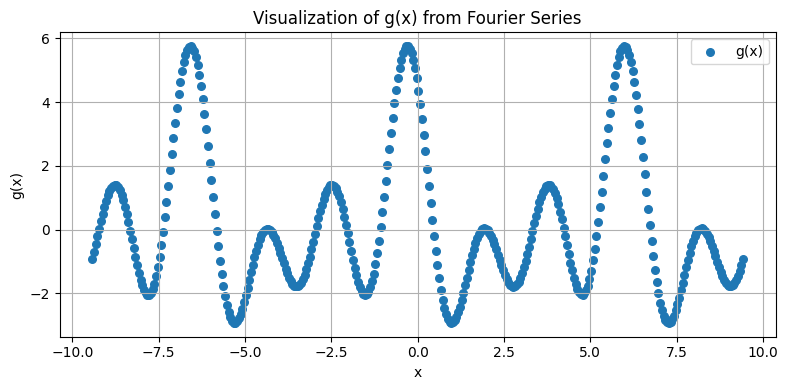

<Figure size 640x480 with 0 Axes>

In [3]:
# Plot using matplotlib
plt.figure(figsize=(8, 4))
plt.scatter(x, g, label="g(x)", s=30)
plt.title("Visualization of g(x) from Fourier Series")
plt.xlabel("x")
plt.ylabel("g(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()

## 2. Model definitions

First off, we define the photonic circuit using Perceval.

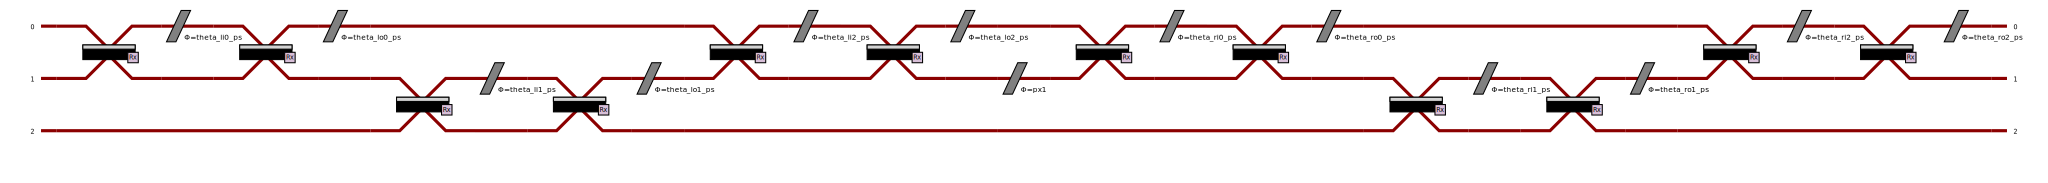

In [4]:
def create_vqc_general(m, input_size):
    """
    Create variational quantum classifier with specified number of modes using general meshes.

    Args:
        m (int): Number of modes in the photonic circuit
        input_size (int): Number of input features to encode

    Returns:
        pcvl.Circuit: The constructed quantum circuit
    """
    wl = pcvl.GenericInterferometer(
        m,
        lambda i: (
            pcvl.BS()
            // pcvl.PS(pcvl.P(f"theta_li{i}_ps"))
            // pcvl.BS()
            // pcvl.PS(pcvl.P(f"theta_lo{i}_ps"))
        ),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )

    c_var = pcvl.Circuit(m)
    for i in range(input_size):
        px = pcvl.P(f"px{i + 1}")
        c_var.add(i + (m - input_size) // 2, pcvl.PS(px))

    wr = pcvl.GenericInterferometer(
        m,
        lambda i: (
            pcvl.BS()
            // pcvl.PS(pcvl.P(f"theta_ri{i}_ps"))
            // pcvl.BS()
            // pcvl.PS(pcvl.P(f"theta_ro{i}_ps"))
        ),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )

    c = pcvl.Circuit(m)
    c.add(0, wl, merge=True)
    c.add(0, c_var, merge=True)
    c.add(0, wr, merge=True)

    return c


def count_parameters(model):
    """
    Count trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): PyTorch model to analyze

    Returns:
        int: Number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


example_circuit = create_vqc_general(3, 1)
pcvl.pdisplay(example_circuit)

We will define a scaling layer for the first layer of our model. It simply multiplies the input by a constant.

In [5]:
class ScaleLayer(nn.Module):
    """
    Multiply the input tensor by a learned or fixed factor.

    Args:
        dim (int): Dimension of the input data to be encoded
        scale_type (str): Type of scaling method. Options:
            - "learned": Learnable parameter initialized randomly
            - "2pi", "/2pi", "pi", "/pi", "2", "/2", "1": Fixed scaling factors
            - "/3pi": Scale by 1/(3π)

    Returns:
        nn.Module that multiplies the input tensor by a scaling factor
    """

    def __init__(self, dim, scale_type="learned"):
        super().__init__()

        if scale_type == "learned":
            self.scale = nn.Parameter(torch.rand(dim))
        elif scale_type == "2pi":
            self.scale = torch.full((dim,), 2 * torch.pi)
        elif scale_type == "/2pi":
            self.scale = torch.full((dim,), 1 / (2 * torch.pi))
        elif scale_type == "/2":
            self.scale = torch.full((dim,), 1 / 2)
        elif scale_type == "2":
            self.scale = torch.full((dim,), 2.0)
        elif scale_type == "pi":
            self.scale = torch.full((dim,), torch.pi)
        elif scale_type == "/pi":
            self.scale = torch.full((dim,), 1 / torch.pi)
        elif scale_type == "1":
            self.scale = torch.full((dim,), 1)
        elif scale_type == "/3pi":
            self.scale = torch.full((dim,), 1 / (3 * torch.pi))

    def forward(self, x):
        """Apply scaling to input tensor."""
        return x * self.scale

Then, we use MerLin's QuantumLayer which allows backpropagation for optimization with gradient descent. It was also designed to be used with PyTorch so this facilitates its usage immensely.

Let's create three quantum layers that each have a different input state to their circuit. Then, let's see how this affects their number of parameters.

In [6]:
def create_quantum_layer(initial_state):
    """
    Create a quantum layer consisting of a VQC for a specific initial state.

    Args:
        initial_state (list): The initial Fock state (e.g., [1, 0, 0] for single photon)

    Returns:
        QuantumLayer: Configured quantum layer for the given initial state
    """
    vqc = QuantumLayer(
        input_size=1,
        circuit=create_vqc_general(3, 1),
        trainable_parameters=["theta"],
        input_parameters=["px"],
        input_state=initial_state,
        measurement_strategy=MeasurementStrategy.probs(
            computation_space=ComputationSpace.FOCK
        ),
    )

    return vqc


def create_model(initial_state):
    """
    Create a complete model with scaling layer and quantum layer.

    Args:
        initial_state (list): The initial Fock state for the quantum layer

    Returns:
        nn.Sequential: Complete model pipeline
    """
    scale_layer = ScaleLayer(1, scale_type="1")
    vqc = create_quantum_layer(initial_state)
    return nn.Sequential(scale_layer, vqc, nn.Linear(vqc.output_size, 1))


# Create models with different photon numbers
vqc_100 = create_model([1, 0, 0])  # Single photon
vqc_110 = create_model([1, 1, 0])  # Two photons
vqc_111 = create_model([1, 1, 1])  # Three photons

models = {"VQC_[1, 0, 0]": vqc_100, "VQC_[1, 1, 0]": vqc_110, "VQC_[1, 1, 1]": vqc_111}

# Display parameter counts
for name, model in models.items():
    print(f"{name}: {count_parameters(model)} parameters")

VQC_[1, 0, 0]: 16 parameters
VQC_[1, 1, 0]: 19 parameters
VQC_[1, 1, 1]: 23 parameters


## 3. Training function

The optimization for the quantum model is as easy as for a classical PyTorch model thanks to MerLin. The structure of the training loop remains the same !

Note that the loss function used for training is the Mean Squared Error (MSE) loss which is useful for regression tasks.

In [7]:
def train_model(
    model,
    x_train,
    y_train,
    model_name,
    n_epochs=120,
    batch_size=32,
    lr=0.02,
    betas=None,
):
    """
    Train a model and return training metrics.

    Args:
        model (nn.Module): The model to train
        x_train (torch.Tensor): Training input data
        y_train (torch.Tensor): Training target data
        model_name (str): Name of the model for logging
        n_epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        lr (float): Learning rate
        betas (list): Beta parameters for Adam optimizer

    Returns:
        dict: Training metrics including losses and MSE values
    """
    if betas is None:
        betas = [0.9, 0.999]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    criterion = nn.MSELoss()

    losses = []
    train_mses = []

    model.train()

    pbar = tqdm(range(n_epochs), desc=f"Training {model_name}")
    for _epoch in pbar:
        permutation = torch.randperm(x_train.size()[0])
        total_loss = 0

        for i in range(0, x_train.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]

            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (x_train.size()[0] // batch_size)
        losses.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_outputs = model(x_train)
            train_mse = mean_squared_error(y_train.numpy(), train_outputs)
            train_mses.append(train_mse)

            pbar.set_description(
                f"Training {model_name} - Loss: {avg_loss:.4f}, Train MSE: {train_mse:.4f}"
            )

        model.train()

    return {
        "losses": losses,
        "train_mses": train_mses,
    }

In [8]:
def train_models_multiple_runs(initial_states, colors, x_train, y_train, num_runs=5):
    """
    Train all models multiple times and return results.

    Args:
        initial_states (list): List of initial Fock states to test
        colors (list): List of colors for plotting
        x_train (np.array): Training input data
        y_train (np.array): Training target data
        num_runs (int): Number of training runs per model

    Returns:
        tuple: (results_dict, best_models_list) containing training results and best models
    """
    results = {}
    models = []

    for initial_state, color in zip(initial_states, colors, strict=False):
        print(f"\nTraining VQC with initial state: {initial_state} ({num_runs} runs):")
        pending_models = []
        model_runs = []

        for run in range(num_runs):
            # Create a fresh instance of the model for each run
            vqc = create_model(initial_state)

            print(f"  Run {run + 1}/{num_runs}...")
            run_results = train_model(
                vqc,
                torch.tensor(x_train, dtype=torch.float).unsqueeze(-1),
                torch.tensor(y_train, dtype=torch.float),
                f"VQC_{initial_state}-run{run + 1}",
            )
            pending_models.append(vqc)
            model_runs.append(run_results)

        # Find and keep the best model for each initial state (lowest final MSE)
        index = torch.argmin(
            torch.tensor([model_run["train_mses"][-1] for model_run in model_runs])
        )

        models.append(pending_models[index])
        # Store all runs for this model
        results[f"VQC_{initial_state}"] = {
            "runs": model_runs,
            "color": color,
        }

    return results, models


# Define training parameters
num_runs = 3
initial_states = [[1, 0, 0], [1, 1, 0], [1, 1, 1]]
colors = ["blue", "orange", "red"]

# Train all models
all_results, models = train_models_multiple_runs(
    initial_states, colors, x, g, num_runs=num_runs
)


Training VQC with initial state: [1, 0, 0] (3 runs):
  Run 1/3...


Training VQC_[1, 0, 0]-run1 - Loss: 4.2438, Train MSE: 3.9094: 100%|██████████| 120/120 [00:02<00:00, 53.86it/s]


  Run 2/3...


Training VQC_[1, 0, 0]-run2 - Loss: 4.2849, Train MSE: 3.9080: 100%|██████████| 120/120 [00:02<00:00, 58.18it/s]


  Run 3/3...


Training VQC_[1, 0, 0]-run3 - Loss: 4.2603, Train MSE: 3.9092: 100%|██████████| 120/120 [00:02<00:00, 58.22it/s]



Training VQC with initial state: [1, 1, 0] (3 runs):
  Run 1/3...


Training VQC_[1, 1, 0]-run1 - Loss: 2.5188, Train MSE: 2.2721: 100%|██████████| 120/120 [00:02<00:00, 56.01it/s]


  Run 2/3...


Training VQC_[1, 1, 0]-run2 - Loss: 2.5006, Train MSE: 2.2792: 100%|██████████| 120/120 [00:02<00:00, 56.19it/s]


  Run 3/3...


Training VQC_[1, 1, 0]-run3 - Loss: 2.4934, Train MSE: 2.2736: 100%|██████████| 120/120 [00:02<00:00, 56.63it/s]



Training VQC with initial state: [1, 1, 1] (3 runs):
  Run 1/3...


Training VQC_[1, 1, 1]-run1 - Loss: 0.0000, Train MSE: 0.0000: 100%|██████████| 120/120 [00:02<00:00, 53.76it/s]


  Run 2/3...


Training VQC_[1, 1, 1]-run2 - Loss: 0.0000, Train MSE: 0.0000: 100%|██████████| 120/120 [00:02<00:00, 54.85it/s]


  Run 3/3...


Training VQC_[1, 1, 1]-run3 - Loss: 0.0000, Train MSE: 0.0000: 100%|██████████| 120/120 [00:02<00:00, 53.97it/s]


## 4. Plot training loss

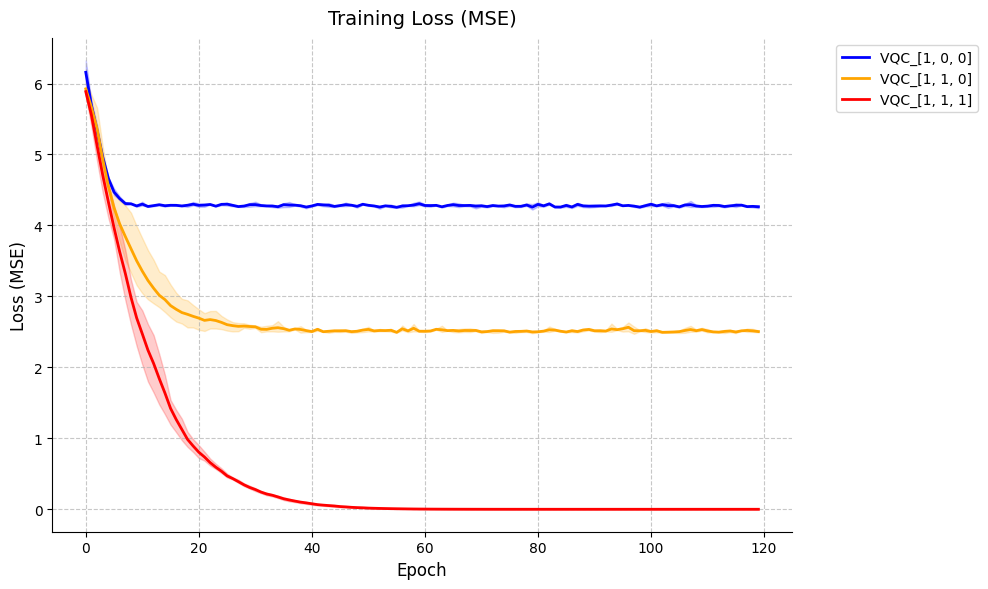

<Figure size 640x480 with 0 Axes>

In [9]:
def plot_training_curves(all_results):
    """
    Plot training curves for all model variants with average and envelope.

    Args:
        all_results (dict): Dictionary containing training results for all models
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot each model's results
    for model_name, model_data in all_results.items():
        color = model_data["color"]
        linestyle = "-"

        # Get data from all runs
        losses_runs = [run["losses"] for run in model_data["runs"]]

        # Calculate mean values across all runs
        epochs = len(losses_runs[0])
        mean_losses = [
            sum(run[i] for run in losses_runs) / len(losses_runs) for i in range(epochs)
        ]

        # Calculate min and max values for the envelope
        min_losses = [min(run[i] for run in losses_runs) for i in range(epochs)]
        max_losses = [max(run[i] for run in losses_runs) for i in range(epochs)]

        # Plot mean line
        ax.plot(
            mean_losses, label=model_name, color=color, linestyle=linestyle, linewidth=2
        )

        # Plot envelope showing variance across runs
        ax.fill_between(range(epochs), min_losses, max_losses, color=color, alpha=0.2)

    # Customize plot
    ax.set_title("Training Loss (MSE)", fontsize=14, pad=10)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss (MSE)", fontsize=12)
    ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    # plt.savefig("./results/expressive_power_vqc_loss.png")  # Uncomment to save locally
    plt.show()
    plt.clf()


# Plot training curves
plot_training_curves(all_results)

## 5. Summary of results

In [10]:
def print_summary_statistics(all_results):
    """
    Print summary statistics for all models.

    Args:
        all_results (dict): Dictionary containing training results for all models
    """
    print("\n----- Model Comparison Results -----\n")

    for model_name, model_data in all_results.items():
        # Calculate statistics across runs
        final_mses = [run["train_mses"][-1] for run in model_data["runs"]]
        avg_mse = sum(final_mses) / len(final_mses)
        min_mse = min(final_mses)
        max_mse = max(final_mses)
        std_mse = (
            sum((mse - avg_mse) ** 2 for mse in final_mses) / len(final_mses)
        ) ** 0.5

        print(f"{model_name}:")
        print(
            f"  Final train MSE: {avg_mse:.6f} ± {std_mse:.6f} (min: {min_mse:.6f}, max: {max_mse:.6f})"
        )
        print()


# Print summary statistics
print_summary_statistics(all_results)


----- Model Comparison Results -----

VQC_[1, 0, 0]:
  Final train MSE: 3.908854 ± 0.000644 (min: 3.907954, max: 3.909424)

VQC_[1, 1, 0]:
  Final train MSE: 2.274965 ± 0.003036 (min: 2.272134, max: 2.279176)

VQC_[1, 1, 1]:
  Final train MSE: 0.000000 ± 0.000000 (min: 0.000000, max: 0.000000)



## 6. Visualize learned functions

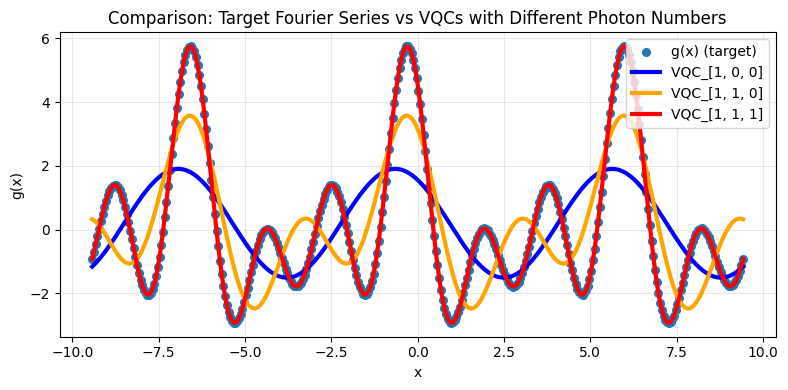

<Figure size 640x480 with 0 Axes>

In [11]:
def visualize_learned_function(models, names, colors, x, g):
    """
    Visualize learned functions of different models compared to the target function g(x).

    Args:
        models (list): List of trained models
        names (list): List of model names
        colors (list): List of colors for each model
        x (np.array): Input domain
        g (np.array): Target function values
    """
    plt.figure(figsize=(8, 4))
    plt.scatter(x, g, label="g(x) (target)", s=30)

    for model, name, color in zip(models, names, colors, strict=False):
        model.eval()
        with torch.no_grad():
            output = model(torch.tensor(x, dtype=torch.float).unsqueeze(-1))
        plt.plot(x, output.detach().numpy(), label=name, color=color, linewidth=3)

    plt.title("Comparison: Target Fourier Series vs VQCs with Different Photon Numbers")
    plt.xlabel("x")
    plt.ylabel("g(x)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    # plt.savefig("./results/expressive_power_of_the_VQC.png")  # Uncomment to save locally
    plt.show()
    plt.clf()


# Define model parameters
names = ["VQC_[1, 0, 0]", "VQC_[1, 1, 0]", "VQC_[1, 1, 1]"]
colors = ["blue", "orange", "red"]

# Visualize results
visualize_learned_function(models, names, colors, x, g)

Hence, this result demonstrates that a quantum model with more input photons is more expressive. [This paper](https://arxiv.org/abs/2107.05224) explains this phenomena by the fact that quantum models with more input photons have access to more basis functions, so they can learn Fourier series with  higher frequencies.